In [2]:
!pip install -U segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 8.5 MB/s 


In [3]:
import os
import numpy as np
import pandas as pd
from skimage import color
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tensorflow as tf
import keras
import segmentation_models as sm
from segmentation_models.utils import set_trainable
import numpy.ma as ma
import torch

Segmentation Models: using `keras` framework.


In [4]:
# Turning on GPU to load data
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

device = tf.device(device_name)

Found GPU at: /device:GPU:0


In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Data Clean Up Functions

Run All

In [6]:
'''
1. split into input and label
2. considered flair, t1, t1c, t2 as multiple inputs
3. repeated the label 4 times to match the inputs
4. considered each of the frames as inputs
'''
def process_samples(data):
  data = np.swapaxes(data, 2, 3)
  data = np.swapaxes(data, 1, 2)
  X = data[:4,:,:,:]
  y = data[4,:,:,:]
  y = np.reshape(y, (1, -1, 240, 240))
  y = np.repeat(y, 4, axis=0)
  return X, y

In [7]:
def three_channels(X, y):
  X = np.stack((X,)*3, axis=-1)
  y = np.stack((y,)*3, axis=-1)
  return X, y

In [8]:
def normalize_data(X):
  X = X/np.max(X)
  return X

In [9]:
def split_labels(label):
    label = label[:, :, :, :, 0] 
    label_ret = np.empty((label.shape[0], label.shape[1], label.shape[2],  label.shape[3], 0))
    for i in range(5):
      if i != 3:
        label_add = np.zeros(label.shape)
        label_add[label == i] = 1
        label_add = label_add[:,:,:,:, np.newaxis]
        label_ret = np.concatenate((label_ret, label_add), axis = 4)
    return label_ret

In [10]:
base_path = "/content/drive/MyDrive/Bioimaging/Bioimagining Project/data"
'''
batch_name : [0,50]
type: HGG or LGG or mix
split: train, val, test

Returns:
X and y 
'''
def load_data(batch_num, type_GG, split):
    file_name = "{}_{}".format(type_GG, split)
    X_file = "{}_X_{}_{}.npy".format(split, type_GG, batch_num)
    y_file = "{}_y_{}_{}.npy".format(split, type_GG, batch_num)
    X_path = os.path.join(base_path, "Unet_data", file_name, X_file)
    y_path = os.path.join(base_path, "Unet_data", file_name, y_file)

    return np.load(X_path), np.load(y_path)

In [11]:
def process_data_more(batch_num, type_GG, split):
  #load and reshape
  X, y = load_data(batch_num, type_GG, split)
  # X = np.reshape(X, (-1, X.shape[2], X.shape[3], X.shape[4]))
  # y = np.reshape(y, (-1, y.shape[2], y.shape[3], y.shape[4]))

  #pad to fit model input
  X = np.pad(X, ((0,0), (0,0), (16, 0), (16, 0), (0,0)), mode = 'constant')
  y = np.pad(y, ((0,0), (0,0), (16, 0), (16, 0), (0,0)), mode = 'constant')

  # split label into classes
  y = split_labels(y)

  nb_mask = np.sum(y[:, :, :, :, 1:], axis = (0, 2, 3, 4)) > 0
  X = X[:, nb_mask, :, :, :]
  y = y[:, nb_mask, :, :, :]

  #convert to tensors
  X = tf.convert_to_tensor(X, dtype=tf.float64)
  y = tf.convert_to_tensor(y, dtype=tf.float32)

  return X, y

In [12]:
# train_X, train_y = process_data_more(0, "mix", "train")
# print(train_y.shape, train_X.shape)


# Load In Data

In [31]:
def initialize_unet(backbone):
  preprocess_input = sm.get_preprocessing(backbone)
  optim = keras.optimizers.Adam(0.0001)
  # define model
  model = sm.Unet(backbone, encoder_weights=None, classes=4, encoder_freeze=False, activation="sigmoid")
  model.compile(
      optim,
      loss=sm.losses.DiceLoss(),
      metrics=[sm.metrics.IOUScore(), sm.metrics.FScore()],
  )
  return model

In [13]:
initialize_unet('resnet101').summary()

94592056/94592056 [==============================] - 20s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                          

In [21]:
train_X, train_y, val_X, val_y = None, None, None, None

In [32]:
optim = keras.optimizers.Adam(0.0001)
num_split = 8
model_name = "inceptionv3_random_weights"
model_path = "/content/drive/MyDrive/Bioimaging/Bioimagining Project/UNet_model/testing_backbones"
model_path = os.path.join(model_path, model_name)

#metrics
loss_lst = []
val_loss_lst = []
iou_lst = []
val_iou_lst = []
f1_lst = []
val_f1_lst = []

for i in range(num_split):
  print(i)
  train_X, train_y = process_data_more(i, "mix", "train")
  val_X, val_y = process_data_more(i, "mix", "val")
  # loading just flair
  # train_X, train_y = train_X[1, :, :, :, :], train_y[1, :, :, :, :]
  # val_X, val_y = val_X[1, :, :, :, :], val_y[1, :, :, :, :]

  # loading in all image modalities
  train_X, train_y = np.reshape(train_X, (-1, train_X.shape[2], train_X.shape[3], train_X.shape[4])) , np.reshape(train_y, (-1, train_y.shape[2], train_y.shape[3], train_y.shape[4]))
  val_X, val_y = np.reshape(val_X, (-1, val_X.shape[2], val_X.shape[3], val_X.shape[4])) , np.reshape(val_y, (-1, val_y.shape[2], val_y.shape[3], val_y.shape[4]))
  # test_X, test_y = process_data_more(i, "mix", "test")

  # print(val_y.shape)
  # print(np.sum(val_y[:, :, :, 3]))

  if os.path.exists(model_path):
    model = keras.models.load_model(model_path, compile = False)
    model.compile(
      optim,
      loss=sm.losses.DiceLoss(),
      metrics=[sm.metrics.IOUScore(), sm.metrics.FScore()],
    )
  else:
    BACKBONE = 'inceptionv3'
    model = initialize_unet(BACKBONE)

  # if num_split < 3:
  #   history = model.fit(
  #   x=train_X,
  #   y=train_y,
  #   batch_size=16,
  #   epochs=3,
  #   validation_data=(val_X, val_y))
    
  #   model.save(model_path)
  #   train_X, train_y, val_X, val_y = None, None, None, None
  # else:
  #   set_trainable(model, recompile=False)

  #   history = model.fit(
  #   x=train_X,
  #   y=train_y,
  #   batch_size=16,
  #   epochs=3,
  #   validation_data=(val_X, val_y))

  history = model.fit(
  x=train_X,
  y=train_y,
  batch_size=16,
  epochs=3,
  validation_data=(val_X, val_y))
    
  # save metrics
  loss_lst.append(history.history['loss'])
  val_loss_lst.append(history.history['val_loss'])
  iou_lst.append(history.history['iou_score'])
  val_iou_lst.append(history.history['val_iou_score'])
  f1_lst.append(history.history['f1-score'])
  val_f1_lst.append(history.history['val_f1-score'])

  model.save(model_path)
  train_X, train_y, val_X, val_y = None, None, None, None

  print(f'loss = {loss_lst}')
  print(f'val_loss = {val_loss_lst}')
  print(f'iou = {iou_lst}')
  print(f'val_iou = {val_iou_lst}')
  print(f'f1 = {f1_lst}')
  print(f'val_f1 = {val_f1_lst}')


0
Epoch 1/3
48/48 [==============================] - 36s 501ms/step - loss: 0.8189 - iou_score: 0.1307 - f1-score: 0.1814 - val_loss: 0.8326 - val_iou_score: 0.1244 - val_f1-score: 0.1674
Epoch 2/3
48/48 [==============================] - 17s 361ms/step - loss: 0.7781 - iou_score: 0.1740 - f1-score: 0.2223 - val_loss: 0.8212 - val_iou_score: 0.1373 - val_f1-score: 0.1788
Epoch 3/3
48/48 [==============================] - 17s 358ms/step - loss: 0.7578 - iou_score: 0.1966 - f1-score: 0.2423 - val_loss: 0.7997 - val_iou_score: 0.1646 - val_f1-score: 0.2002


loss = [[0.8188801407814026, 0.7781270146369934, 0.7578425407409668]]
val_loss = [[0.8325760960578918, 0.8211814761161804, 0.7997347116470337]]
iou = [[0.13073042035102844, 0.17398928105831146, 0.19660182297229767]]
val_iou = [[0.12443860620260239, 0.13726983964443207, 0.16457824409008026]]
f1 = [[0.18141065537929535, 0.22231119871139526, 0.24226002395153046]]
val_f1 = [[0.1673860102891922, 0.17877568304538727, 0.20022527873516083]]
1


Epoch 1/3
60/60 [==============================] - 36s 479ms/step - loss: 0.7365 - iou_score: 0.2150 - f1-score: 0.2635 - val_loss: 0.7737 - val_iou_score: 0.1839 - val_f1-score: 0.2259
Epoch 2/3
60/60 [==============================] - 23s 376ms/step - loss: 0.7193 - iou_score: 0.2311 - f1-score: 0.2807 - val_loss: 0.7675 - val_iou_score: 0.1952 - val_f1-score: 0.2322
Epoch 3/3
60/60 [==============================] - 22s 371ms/step - loss: 0.7043 - iou_score: 0.2445 - f1-score: 0.2957 - val_loss: 0.7528 - val_iou_score: 0.2046 - val_f1-score: 0.2466


loss = [[0.8188801407814026, 0.7781270146369934, 0.7578425407409668], [0.7364827394485474, 0.7193372249603271, 0.7043007612228394]]
val_loss = [[0.8325760960578918, 0.8211814761161804, 0.7997347116470337], [0.7736629247665405, 0.7674804329872131, 0.7528494596481323]]
iou = [[0.13073042035102844, 0.17398928105831146, 0.19660182297229767], [0.21496698260307312, 0.23110654950141907, 0.24447153508663177]]
val_iou = [[0.12443860620260239, 0.13726983964443207, 0.16457824409008026], [0.18394871056079865, 0.19517205655574799, 0.20458754897117615]]
f1 = [[0.18141065537929535, 0.22231119871139526, 0.24226002395153046], [0.2635205090045929, 0.2807270288467407, 0.2956763803958893]]
val_f1 = [[0.1673860102891922, 0.17877568304538727, 0.20022527873516083], [0.22591754794120789, 0.23217451572418213, 0.2465662658214569]]
2


Epoch 1/3
61/61 [==============================] - 32s 394ms/step - loss: 0.7277 - iou_score: 0.2362 - f1-score: 0.2724 - val_loss: 0.7346 - val_iou_score: 0.2357 - val_f1-score: 0.2646
Epoch 2/3
61/61 [==============================] - 22s 366ms/step - loss: 0.6871 - iou_score: 0.2682 - f1-score: 0.3129 - val_loss: 0.7166 - val_iou_score: 0.2542 - val_f1-score: 0.2826
Epoch 3/3
61/61 [==============================] - 22s 362ms/step - loss: 0.6538 - iou_score: 0.2935 - f1-score: 0.3464 - val_loss: 0.7072 - val_iou_score: 0.2631 - val_f1-score: 0.2918


loss = [[0.8188801407814026, 0.7781270146369934, 0.7578425407409668], [0.7364827394485474, 0.7193372249603271, 0.7043007612228394], [0.727748692035675, 0.6870954632759094, 0.6537639498710632]]
val_loss = [[0.8325760960578918, 0.8211814761161804, 0.7997347116470337], [0.7736629247665405, 0.7674804329872131, 0.7528494596481323], [0.7345631122589111, 0.7166155576705933, 0.7071964740753174]]
iou = [[0.13073042035102844, 0.17398928105831146, 0.19660182297229767], [0.21496698260307312, 0.23110654950141907, 0.24447153508663177], [0.23619267344474792, 0.2681632339954376, 0.293549507856369]]
val_iou = [[0.12443860620260239, 0.13726983964443207, 0.16457824409008026], [0.18394871056079865, 0.19517205655574799, 0.20458754897117615], [0.2356758862733841, 0.2541574537754059, 0.2631126344203949]]
f1 = [[0.18141065537929535, 0.22231119871139526, 0.24226002395153046], [0.2635205090045929, 0.2807270288467407, 0.2956763803958893], [0.2724376916885376, 0.31289151310920715, 0.34636417031288147]]
val_f1 = [

Epoch 1/3
45/45 [==============================] - 26s 417ms/step - loss: 0.6124 - iou_score: 0.3231 - f1-score: 0.3880 - val_loss: 0.7565 - val_iou_score: 0.2345 - val_f1-score: 0.2435
Epoch 2/3
45/45 [==============================] - 17s 384ms/step - loss: 0.5528 - iou_score: 0.3657 - f1-score: 0.4451 - val_loss: 0.7282 - val_iou_score: 0.2501 - val_f1-score: 0.2715
Epoch 3/3
45/45 [==============================] - 17s 380ms/step - loss: 0.5133 - iou_score: 0.3984 - f1-score: 0.4876 - val_loss: 0.7346 - val_iou_score: 0.2467 - val_f1-score: 0.2652


loss = [[0.8188801407814026, 0.7781270146369934, 0.7578425407409668], [0.7364827394485474, 0.7193372249603271, 0.7043007612228394], [0.727748692035675, 0.6870954632759094, 0.6537639498710632], [0.6123915910720825, 0.552790641784668, 0.5132986903190613]]
val_loss = [[0.8325760960578918, 0.8211814761161804, 0.7997347116470337], [0.7736629247665405, 0.7674804329872131, 0.7528494596481323], [0.7345631122589111, 0.7166155576705933, 0.7071964740753174], [0.7564936280250549, 0.7281981110572815, 0.7345504760742188]]
iou = [[0.13073042035102844, 0.17398928105831146, 0.19660182297229767], [0.21496698260307312, 0.23110654950141907, 0.24447153508663177], [0.23619267344474792, 0.2681632339954376, 0.293549507856369], [0.3231372535228729, 0.3656904101371765, 0.3984397053718567]]
val_iou = [[0.12443860620260239, 0.13726983964443207, 0.16457824409008026], [0.18394871056079865, 0.19517205655574799, 0.20458754897117615], [0.2356758862733841, 0.2541574537754059, 0.2631126344203949], [0.2345493733882904, 0

Epoch 1/3
60/60 [==============================] - 31s 393ms/step - loss: 0.5446 - iou_score: 0.3741 - f1-score: 0.4560 - val_loss: 0.7541 - val_iou_score: 0.2411 - val_f1-score: 0.2460
Epoch 2/3
60/60 [==============================] - 22s 369ms/step - loss: 0.4433 - iou_score: 0.4471 - f1-score: 0.5566 - val_loss: 0.7498 - val_iou_score: 0.2471 - val_f1-score: 0.2502
Epoch 3/3
60/60 [==============================] - 22s 364ms/step - loss: 0.3926 - iou_score: 0.4896 - f1-score: 0.6071 - val_loss: 0.7508 - val_iou_score: 0.2468 - val_f1-score: 0.2492


loss = [[0.8188801407814026, 0.7781270146369934, 0.7578425407409668], [0.7364827394485474, 0.7193372249603271, 0.7043007612228394], [0.727748692035675, 0.6870954632759094, 0.6537639498710632], [0.6123915910720825, 0.552790641784668, 0.5132986903190613], [0.5445669889450073, 0.44327303767204285, 0.3926238417625427]]
val_loss = [[0.8325760960578918, 0.8211814761161804, 0.7997347116470337], [0.7736629247665405, 0.7674804329872131, 0.7528494596481323], [0.7345631122589111, 0.7166155576705933, 0.7071964740753174], [0.7564936280250549, 0.7281981110572815, 0.7345504760742188], [0.7541047930717468, 0.7498012185096741, 0.7507910132408142]]
iou = [[0.13073042035102844, 0.17398928105831146, 0.19660182297229767], [0.21496698260307312, 0.23110654950141907, 0.24447153508663177], [0.23619267344474792, 0.2681632339954376, 0.293549507856369], [0.3231372535228729, 0.3656904101371765, 0.3984397053718567], [0.37409883737564087, 0.44711655378341675, 0.48961812257766724]]
val_iou = [[0.12443860620260239, 0.

Epoch 1/3
53/53 [==============================] - 31s 444ms/step - loss: 0.4822 - iou_score: 0.4199 - f1-score: 0.5171 - val_loss: 0.7265 - val_iou_score: 0.2584 - val_f1-score: 0.2728
Epoch 2/3
53/53 [==============================] - 20s 374ms/step - loss: 0.3692 - iou_score: 0.5071 - f1-score: 0.6309 - val_loss: 0.6966 - val_iou_score: 0.2789 - val_f1-score: 0.3036
Epoch 3/3
53/53 [==============================] - 20s 370ms/step - loss: 0.3496 - iou_score: 0.5267 - f1-score: 0.6509 - val_loss: 0.7038 - val_iou_score: 0.2780 - val_f1-score: 0.2992


loss = [[0.8188801407814026, 0.7781270146369934, 0.7578425407409668], [0.7364827394485474, 0.7193372249603271, 0.7043007612228394], [0.727748692035675, 0.6870954632759094, 0.6537639498710632], [0.6123915910720825, 0.552790641784668, 0.5132986903190613], [0.5445669889450073, 0.44327303767204285, 0.3926238417625427], [0.48219653964042664, 0.36921608448028564, 0.3495602607727051]]
val_loss = [[0.8325760960578918, 0.8211814761161804, 0.7997347116470337], [0.7736629247665405, 0.7674804329872131, 0.7528494596481323], [0.7345631122589111, 0.7166155576705933, 0.7071964740753174], [0.7564936280250549, 0.7281981110572815, 0.7345504760742188], [0.7541047930717468, 0.7498012185096741, 0.7507910132408142], [0.7265301942825317, 0.6966084837913513, 0.703770101070404]]
iou = [[0.13073042035102844, 0.17398928105831146, 0.19660182297229767], [0.21496698260307312, 0.23110654950141907, 0.24447153508663177], [0.23619267344474792, 0.2681632339954376, 0.293549507856369], [0.3231372535228729, 0.36569041013717

Epoch 1/3
40/40 [==============================] - 25s 431ms/step - loss: 0.5465 - iou_score: 0.3724 - f1-score: 0.4540 - val_loss: 0.7533 - val_iou_score: 0.2435 - val_f1-score: 0.2467
Epoch 2/3
40/40 [==============================] - 16s 391ms/step - loss: 0.4276 - iou_score: 0.4607 - f1-score: 0.5716 - val_loss: 0.7517 - val_iou_score: 0.2443 - val_f1-score: 0.2483
Epoch 3/3
40/40 [==============================] - 16s 396ms/step - loss: 0.3896 - iou_score: 0.4910 - f1-score: 0.6095 - val_loss: 0.7509 - val_iou_score: 0.2447 - val_f1-score: 0.2491


loss = [[0.8188801407814026, 0.7781270146369934, 0.7578425407409668], [0.7364827394485474, 0.7193372249603271, 0.7043007612228394], [0.727748692035675, 0.6870954632759094, 0.6537639498710632], [0.6123915910720825, 0.552790641784668, 0.5132986903190613], [0.5445669889450073, 0.44327303767204285, 0.3926238417625427], [0.48219653964042664, 0.36921608448028564, 0.3495602607727051], [0.5464773774147034, 0.42761752009391785, 0.38955846428871155]]
val_loss = [[0.8325760960578918, 0.8211814761161804, 0.7997347116470337], [0.7736629247665405, 0.7674804329872131, 0.7528494596481323], [0.7345631122589111, 0.7166155576705933, 0.7071964740753174], [0.7564936280250549, 0.7281981110572815, 0.7345504760742188], [0.7541047930717468, 0.7498012185096741, 0.7507910132408142], [0.7265301942825317, 0.6966084837913513, 0.703770101070404], [0.7533223628997803, 0.7517306208610535, 0.7509192228317261]]
iou = [[0.13073042035102844, 0.17398928105831146, 0.19660182297229767], [0.21496698260307312, 0.23110654950141

Epoch 1/3
73/73 [==============================] - 37s 405ms/step - loss: 0.4578 - iou_score: 0.4378 - f1-score: 0.5410 - val_loss: 0.6800 - val_iou_score: 0.2899 - val_f1-score: 0.3182
Epoch 2/3
73/73 [==============================] - 28s 382ms/step - loss: 0.3405 - iou_score: 0.5387 - f1-score: 0.6591 - val_loss: 0.6869 - val_iou_score: 0.2888 - val_f1-score: 0.3115
Epoch 3/3
73/73 [==============================] - 27s 377ms/step - loss: 0.3083 - iou_score: 0.5729 - f1-score: 0.6918 - val_loss: 0.6993 - val_iou_score: 0.2807 - val_f1-score: 0.2995


loss = [[0.8188801407814026, 0.7781270146369934, 0.7578425407409668], [0.7364827394485474, 0.7193372249603271, 0.7043007612228394], [0.727748692035675, 0.6870954632759094, 0.6537639498710632], [0.6123915910720825, 0.552790641784668, 0.5132986903190613], [0.5445669889450073, 0.44327303767204285, 0.3926238417625427], [0.48219653964042664, 0.36921608448028564, 0.3495602607727051], [0.5464773774147034, 0.42761752009391785, 0.38955846428871155], [0.4578278660774231, 0.3405422270298004, 0.30831754207611084]]
val_loss = [[0.8325760960578918, 0.8211814761161804, 0.7997347116470337], [0.7736629247665405, 0.7674804329872131, 0.7528494596481323], [0.7345631122589111, 0.7166155576705933, 0.7071964740753174], [0.7564936280250549, 0.7281981110572815, 0.7345504760742188], [0.7541047930717468, 0.7498012185096741, 0.7507910132408142], [0.7265301942825317, 0.6966084837913513, 0.703770101070404], [0.7533223628997803, 0.7517306208610535, 0.7509192228317261], [0.6800112724304199, 0.6869252324104309, 0.6992

# Model

In [ ]:
# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
# model.fit(
#    x=train_X,
#    y=train_y,
#    batch_size=32,
#    epochs=1,
#    validation_data=(val_X, val_y),
# )

In [ ]:
# model.summary()

In [ ]:
test_X, test_y = process_data_more(1, "mix", "test")
print(model.metrics_names)
model.evaluate(
   x=test_X,
   y=test_y,
   batch_size=32
)
test_y = np.argmax(test_y, axis = 3)

In [ ]:
pred_y = model(test_X[0:150, :, :, :])
pred_y = np.argmax(pred_y, axis = 3)


In [ ]:
frame = 70
fig, ax = plt.subplots(1, 2)
im0 = ax[0].imshow(pred_y[frame, :, :])
colors = np.unique(pred_y[frame, :, :])
plt.colorbar(im0, ax = ax[0])
im1 = ax[1].imshow(test_y[frame, :, :])
colors = np.unique(test_y[frame, :, :])
plt.colorbar(im1, ax = ax[1])


In [ ]:
pred_y_1 = np.argmax(pred_y, axis = 3)
pred_y_1 
print(pred_y_1[100, :, :])

In [ ]:
def int_and_union(img, gt): 
    intersection = np.sum(img & gt)
    union = tf.size(img) + tf.size(gt)
    return intersection, union 

def dice_coef(intersection_arr, union_arr, smooth=0.0001):
  return 2 * (np.sum(intersection_arr) + smooth) / (np.sum(union_arr) + smooth)

In [ ]:
model_name = "inceptionv3"
model_path = "/content/drive/MyDrive/Bioimaging/Bioimagining Project/UNet_model/testing_backbones"
model_path = os.path.join(model_path, model_name)
optim = keras.optimizers.Adam(0.0001)
model = keras.models.load_model(model_path, compile = False)
model.compile(
  optim,
  loss=sm.losses.DiceLoss(),
  metrics=[sm.metrics.IOUScore(), sm.metrics.FScore()],
)
num_split = 5
for i in range(num_split): 
  test_X, test_y = process_data_more(i, "mix", "test")
  #collasing image modalities
  test_X, test_y = np.reshape(test_X, (-1, test_X.shape[2], test_X.shape[3], test_X.shape[4])) , np.reshape(test_y, (-1, test_y.shape[2], test_y.shape[3], test_y.shape[4]))
  print(test_X.shape, test_y.shape)
  # for sub in range(0, test_X.shape[0], 25): 
  #   pred_y = model(test_X[sub:max(sub+25, test_X.shape[0])])
  # pred_y = model(test_X)
  # pred_y = np.argmax(pred_y, axis = 3)
  # pred_y = np.eye(4)[pred_y]
  # test_y = tf.cast(test_y, bool)
  # pred_y = tf.cast(pred_y, bool)
  # _, _, dc = model.evaluate(
  #   x=test_X,
  #   y=test_y,
  #   batch_size=32
  # )

  # intersection, union = int_and_union(pred_y, test_y)


  dice = sm.metrics.FScore()

  dice_path = "/content/drive/MyDrive/Bioimaging/Bioimagining Project/Dice"
  batch_sz = 64
  for sub in range(0, test_X.shape[0], batch_sz):
    pred_y = model(test_X[sub:min(sub+batch_sz, test_X.shape[0])])
    pred_y = np.argmax(pred_y, axis = 3)
    pred_y = np.eye(4)[pred_y]
    bwhole_y = np.max(pred_y[:, :, :, 1:], axis = 3)
    btest_y = np.max(test_y[sub:min(sub+batch_sz, test_X.shape[0]), :, :, 1:], axis = 3)
    dc = dice(bwhole_y.astype('float32'), btest_y.astype('float32'))

    for label in range(pred_y.shape[3]): 
      ldc = dice(pred_y[:, :, :, label].astype('float32'), test_y[sub:min(sub+batch_sz, test_X.shape[0]), :, :, label].astype('float32'))
      fname = os.path.join(dice_path, f"UNET_DC_{label}_final")
      arr = np.array([])
      if os.path.exists(fname):
          with open(fname, 'rb') as f:
            arr = np.load(f)
      arr = np.append(arr, ldc)
      with open(fname, 'wb') as f:
        np.save(f, arr)

    fname = os.path.join(dice_path, "UNET_DC_AVG_final")
    arr = np.array([])
    if os.path.exists(fname):
        with open(fname, 'rb') as f:
          arr = np.load(f)
    arr = np.append(arr, dc)
    with open(fname, 'wb') as f:
      np.save(f, arr)
  
  fname = os.path.join(dice_path, "UNET_DC_AVG_final")
  arr = np.array([])
  if os.path.exists(fname):
      with open(fname, 'rb') as f:
        arr = np.load(f)
  print("Moving Dice Score at {}: {}".format(i, np.mean(arr)))

  for label in range(pred_y.shape[3]): 
    fname = os.path.join(dice_path, f"UNET_DC_{label}_final")
    arr = np.array([])
    if os.path.exists(fname):
        with open(fname, 'rb') as f:
          arr = np.load(f)
    print("Moving Dice Score for label {} at {}: {}".format(label, i, np.mean(arr)))
  
  
  # iu_list = [intersection, union]
  # names = ["UNet_intersection.npy", "UNet_union.npy"]
  # iu = [np.array([]), np.array([])]

  # for j in range(2): 
  #   var = names[j]
  #   fname = os.path.join(dice_path, var)
  #   if os.path.exists(fname):
  #     with open(fname, 'rb') as f:
  #       iu[j] = np.load(f)
  #   iu[j] = np.append(iu[j], iu_list[j])
  #   with open(fname, 'wb') as f:
  #       np.save(f, iu[j])

  #print("Moving Dice Score at {}: {}".format(i, dice_coef(iu[0], iu[1])))



# Graph Dice Score For Each Backbone

In [16]:
#storing the metrics from the backbones
resnet50_loss = [[0.7879551649093628, 0.7593932747840881, 0.7378212809562683], [0.7011888027191162, 0.6633612513542175, 0.6224138140678406], [0.6527939438819885, 0.5509492754936218, 0.4668409526348114], [0.4772278964519501, 0.3954712748527527, 0.34577369689941406], [0.3965983986854553, 0.3187200427055359, 0.30004820227622986], [0.38760846853256226, 0.3181442320346832, 0.28009676933288574], [0.4849643409252167, 0.37103259563446045, 0.32160043716430664], [0.376954585313797, 0.30044466257095337, 0.28112977743148804]]
resnet50_val_loss = [[0.8243169188499451, 0.809008777141571, 0.7949939370155334], [0.7718115448951721, 0.7585475444793701, 0.7585102319717407], [0.7592375874519348, 0.7556002140045166, 0.7544134855270386], [0.7606012225151062, 0.7536842226982117, 0.7544841170310974], [0.7600233554840088, 0.7546712756156921, 0.751515805721283], [0.7388262152671814, 0.7390796542167664, 0.7166311144828796], [0.7527754306793213, 0.7483220100402832, 0.7530786395072937], [0.6881650686264038, 0.7104319334030151, 0.6912964582443237]]
resnet50_iou = [[0.16498930752277374, 0.1943919062614441, 0.21273504197597504], [0.23869243264198303, 0.2677282392978668, 0.2977113723754883], [0.2889914810657501, 0.36145755648612976, 0.42681723833084106], [0.4298529028892517, 0.49873122572898865, 0.5373402833938599], [0.4890742599964142, 0.5592390298843384, 0.5803526043891907], [0.4954620599746704, 0.5572100877761841, 0.5953987836837769], [0.4181036055088043, 0.5095897912979126, 0.555915892124176], [0.5086527466773987, 0.5837945342063904, 0.6063504219055176]]
resnet50_val_iou = [[0.13401316106319427, 0.15281321108341217, 0.1715642362833023], [0.20140309631824493, 0.2138136476278305, 0.21589592099189758], [0.2294342815876007, 0.23533402383327484, 0.2394738346338272], [0.22679929435253143, 0.23858903348445892, 0.23826229572296143], [0.23067647218704224, 0.24070273339748383, 0.24698229134082794], [0.25423476099967957, 0.2546796202659607, 0.271764874458313], [0.24376903474330902, 0.24612300097942352, 0.24361826479434967], [0.28682026267051697, 0.27195897698402405, 0.2853172719478607]]
resnet50_f1 = [[0.21227021515369415, 0.2410014122724533, 0.2621016800403595], [0.29888615012168884, 0.33666449785232544, 0.3777059018611908], [0.3472667932510376, 0.4490283131599426, 0.5331597328186035], [0.5233662724494934, 0.6052267551422119, 0.6517853736877441], [0.6037927269935608, 0.681239128112793, 0.6999491453170776], [0.6120728254318237, 0.6816152334213257, 0.7191130518913269], [0.515923798084259, 0.6281871199607849, 0.6788902878761292], [0.6241164803504944, 0.7007315754890442, 0.7191888093948364]]
resnet50_val_f1 = [[0.1756482571363449, 0.19095547497272491, 0.20496565103530884], [0.2280929833650589, 0.24119660258293152, 0.24125497043132782], [0.24076059460639954, 0.24439096450805664, 0.24560996890068054], [0.23946122825145721, 0.24665242433547974, 0.24570952355861664], [0.2399417906999588, 0.24529677629470825, 0.2485237419605255], [0.261624813079834, 0.26196274161338806, 0.28683412075042725], [0.24727651476860046, 0.25162380933761597, 0.24698039889335632], [0.31028759479522705, 0.28857743740081787, 0.30723467469215393]]

resnet101_loss = [[0.7771645188331604, 0.7506430745124817, 0.7334888577461243], [0.7027075290679932, 0.6639189124107361, 0.6205806732177734], [0.6505968570709229, 0.5591710805892944, 0.4964654743671417], [0.5124137997627258, 0.4364078640937805, 0.40238404273986816], [0.4191547930240631, 0.33815866708755493, 0.3184609115123749], [0.43813207745552063, 0.3878004848957062, 0.35018935799598694], [0.4417520761489868, 0.3605234920978546, 0.3295137882232666], [0.39564618468284607, 0.31820493936538696, 0.29689985513687134]]
resnet101_val_loss = [[0.8240801095962524, 0.8023602962493896, 0.7914877533912659], [0.7663126587867737, 0.7702152132987976, 0.7671477198600769], [0.7443118095397949, 0.7519775032997131, 0.7515674233436584], [0.7432909607887268, 0.7532645463943481, 0.7554884552955627], [0.7514534592628479, 0.7514733672142029, 0.7514374852180481], [0.7060902118682861, 0.704928994178772, 0.7134392261505127], [0.7498098015785217, 0.7526485323905945, 0.7533682584762573], [0.7259829640388489, 0.7080753445625305, 0.7112789154052734]]
resnet101_iou = [[0.17764829099178314, 0.2067386955022812, 0.22177372872829437], [0.24106214940547943, 0.2687637209892273, 0.3019804358482361], [0.29265713691711426, 0.35877060890197754, 0.40768688917160034], [0.40150293707847595, 0.46403682231903076, 0.4906763434410095], [0.46726831793785095, 0.537034809589386, 0.5566297769546509], [0.4510829448699951, 0.4924090504646301, 0.5270769596099854], [0.45054787397384644, 0.5227848291397095, 0.5496675968170166], [0.487341046333313, 0.5622805953025818, 0.5824544429779053]]
resnet101_val_iou = [[0.1341923475265503, 0.16152022778987885, 0.17657005786895752], [0.20381034910678864, 0.206505686044693, 0.21174418926239014], [0.24014391005039215, 0.23992106318473816, 0.24221272766590118], [0.24184246361255646, 0.23820094764232635, 0.23788456618785858], [0.24689991772174835, 0.24696072936058044, 0.2470654994249344], [0.276283323764801, 0.27927783131599426, 0.27498072385787964], [0.24525941908359528, 0.24383513629436493, 0.24348323047161102], [0.261363685131073, 0.2746374011039734, 0.2711193263530731]]
resnet101_f1 = [[0.2234058380126953, 0.24935370683670044, 0.26631590723991394], [0.297425240278244, 0.33611565828323364, 0.37958747148513794], [0.3495529890060425, 0.4409255385398865, 0.5035539865493774], [0.48941799998283386, 0.5644075870513916, 0.5981176495552063], [0.5811565518379211, 0.6616805195808411, 0.6809409260749817], [0.561609148979187, 0.611956775188446, 0.6482846736907959], [0.5597147345542908, 0.6397892236709595, 0.6689758896827698], [0.6021480560302734, 0.6827946305274963, 0.7041534781455994]]
resnet101_val_f1 = [[0.17588120698928833, 0.19760878384113312, 0.20847810804843903], [0.23345792293548584, 0.22974534332752228, 0.23281452059745789], [0.2554832100868225, 0.24799729883670807, 0.24843697249889374], [0.2565842270851135, 0.2467673271894455, 0.24456508457660675], [0.2485826164484024, 0.24856430292129517, 0.2486000657081604], [0.29534852504730225, 0.29770520329475403, 0.29076552391052246], [0.2501721680164337, 0.2474006712436676, 0.24669793248176575], [0.27341514825820923, 0.29087507724761963, 0.2877518832683563]]

resnet152_loss = [[0.7763594388961792, 0.7519401907920837, 0.7352164387702942], [0.7023773193359375, 0.6691094636917114, 0.6321956515312195], [0.45959407091140747, 0.3921683728694916, 0.3686385154724121], [0.3967267572879791, 0.305008202791214, 0.2851041853427887], [0.3382469713687897, 0.2835255563259125, 0.25929948687553406], [0.35796308517456055, 0.290127158164978, 0.26421037316322327], [0.3945644795894623, 0.31469038128852844, 0.2891267240047455], [0.33862602710723877, 0.2722046971321106, 0.25283098220825195]]
resnet152_val_loss = [[0.8211139440536499, 0.7958036661148071, 0.7797771692276001], [0.7593222260475159, 0.7539650201797485, 0.7523435950279236], [0.707485556602478, 0.6331126689910889, 0.6462658643722534], [0.7553091645240784, 0.7506780028343201, 0.7448670864105225], [0.7630582451820374, 0.7517072558403015, 0.751625120639801], [0.7211676836013794, 0.7214691638946533, 0.6978663802146912], [0.753860354423523, 0.7530373930931091, 0.7509525418281555], [0.7088189125061035, 0.7045033574104309, 0.7130632400512695]]
resnet152_iou = [[0.18361151218414307, 0.21182465553283691, 0.2270217090845108], [0.2510913014411926, 0.27635300159454346, 0.3023340106010437], [0.446155846118927, 0.5050620436668396, 0.5241140723228455], [0.4955092966556549, 0.5748300552368164, 0.594921886920929], [0.5416241884231567, 0.5982872247695923, 0.6238711476325989], [0.5267007946968079, 0.5890340805053711, 0.6179973483085632], [0.4906133711338043, 0.5636258125305176, 0.5903090834617615], [0.5506965517997742, 0.615418016910553, 0.6318472027778625]]
resnet152_val_iou = [[0.13767682015895844, 0.17071212828159332, 0.19313038885593414], [0.21473920345306396, 0.224762961268425, 0.2186223864555359], [0.2723206579685211, 0.32752159237861633, 0.3170638978481293], [0.23837365210056305, 0.24139726161956787, 0.24582070112228394], [0.22509028017520905, 0.24670453369617462, 0.24685977399349213], [0.26863932609558105, 0.2731929123401642, 0.291794091463089], [0.24252423644065857, 0.24317112565040588, 0.24443383514881134], [0.27196094393730164, 0.273416668176651, 0.26866891980171204]]
resnet152_f1 = [[0.2237609177827835, 0.24827782809734344, 0.2646101415157318], [0.29766350984573364, 0.3309953510761261, 0.36795327067375183], [0.5398064851760864, 0.6070608496665955, 0.6312563419342041], [0.6033281683921814, 0.6945769190788269, 0.7124236226081848], [0.6616504788398743, 0.7169334292411804, 0.7410122156143188], [0.6435455679893494, 0.709531307220459, 0.7363661527633667], [0.6042520999908447, 0.6852537393569946, 0.7110119462013245], [0.6629402041435242, 0.7294703722000122, 0.7442994117736816]]
resnet152_val_f1 = [[0.1788507103919983, 0.20416666567325592, 0.2201622873544693], [0.24045442044734955, 0.2458345741033554, 0.24727417528629303], [0.2912743389606476, 0.3635460436344147, 0.35177335143089294], [0.24474184215068817, 0.24931323528289795, 0.25504830479621887], [0.2368946671485901, 0.24834021925926208, 0.24842047691345215], [0.2828851342201233, 0.2857811748981476, 0.3117929697036743], [0.24620380997657776, 0.24701640009880066, 0.24905236065387726], [0.2901497483253479, 0.2943483889102936, 0.2860119938850403]]

inceptionv3_loss = [[0.7797020077705383, 0.7593450546264648, 0.7468422651290894], [0.7202137112617493, 0.6963803172111511, 0.6693705916404724], [0.6903361678123474, 0.6356477737426758, 0.5708356499671936], [0.5212912559509277, 0.4443252980709076, 0.4239729642868042], [0.43238866329193115, 0.3484017550945282, 0.32074323296546936], [0.4457768499851227, 0.40020591020584106, 0.3849982023239136], [0.5128067135810852, 0.4059673249721527, 0.34512758255004883], [0.38516512513160706, 0.3162570893764496, 0.2934053838253021]]
inceptionv3_val_loss = [[0.8257288932800293, 0.8070414066314697, 0.7846840620040894], [0.7544863820075989, 0.747951090335846, 0.7425230741500854], [0.7193540930747986, 0.6991463303565979, 0.7141351103782654], [0.7419487237930298, 0.7522817254066467, 0.7324791550636292], [0.7510094046592712, 0.7506714463233948, 0.7501920461654663], [0.7087649703025818, 0.6769055128097534, 0.7015191316604614], [0.7458603382110596, 0.7069078683853149, 0.7318136692047119], [0.6925674080848694, 0.6760133504867554, 0.6689257621765137]]
inceptionv3_iou = [[0.17774797976016998, 0.20130574703216553, 0.21505983173847198], [0.23598502576351166, 0.25637713074684143, 0.2770247459411621], [0.26960036158561707, 0.3074813187122345, 0.35272666811943054], [0.3953428566455841, 0.46035242080688477, 0.47858139872550964], [0.45855727791786194, 0.5317662358283997, 0.5581175088882446], [0.44599318504333496, 0.483539879322052, 0.4965907037258148], [0.3939852714538574, 0.47675299644470215, 0.5337596535682678], [0.5011935234069824, 0.563569188117981, 0.5840611457824707]]
inceptionv3_val_iou = [[0.13196291029453278, 0.15447776019573212, 0.1851528435945511], [0.2080896645784378, 0.22091202437877655, 0.23008133471012115], [0.25553205609321594, 0.2719267010688782, 0.26374316215515137], [0.24396049976348877, 0.23879645764827728, 0.2511572539806366], [0.2468901127576828, 0.2472243756055832, 0.24726717174053192], [0.2540075480937958, 0.29230692982673645, 0.28071433305740356], [0.24733778834342957, 0.2707441449165344, 0.25489872694015503], [0.27992212772369385, 0.29497024416923523, 0.3007771670818329]]
inceptionv3_f1 = [[0.2205483764410019, 0.24048806726932526, 0.252835214138031], [0.27988922595977783, 0.3036753535270691, 0.33069026470184326], [0.3096725046634674, 0.3645089864730835, 0.429118275642395], [0.47983211278915405, 0.5563607215881348, 0.576624870300293], [0.5675140023231506, 0.6516773700714111, 0.6794394254684448], [0.5540623068809509, 0.5994725227355957, 0.6151788830757141], [0.48719125986099243, 0.5921955704689026, 0.6548227071762085], [0.6161919236183167, 0.6832000017166138, 0.7045984268188477]]
inceptionv3_val_f1 = [[0.174213245511055, 0.19297616183757782, 0.21527214348316193], [0.2451227754354477, 0.25171107053756714, 0.2571113407611847], [0.27998510003089905, 0.2993660867214203, 0.28488633036613464], [0.257953405380249, 0.24774235486984253, 0.26769980788230896], [0.24902497231960297, 0.2493484616279602, 0.24980810284614563], [0.289883017539978, 0.3232077658176422, 0.3018438518047333], [0.2540276348590851, 0.29204949736595154, 0.26773491501808167], [0.3059954047203064, 0.32213571667671204, 0.3290460705757141]]

inceptionv3_random_loss = [[0.8188801407814026, 0.7781270146369934, 0.7578425407409668], [0.7364827394485474, 0.7193372249603271, 0.7043007612228394], [0.727748692035675, 0.6870954632759094, 0.6537639498710632], [0.6123915910720825, 0.552790641784668, 0.5132986903190613], [0.5445669889450073, 0.44327303767204285, 0.3926238417625427], [0.48219653964042664, 0.36921608448028564, 0.3495602607727051], [0.5464773774147034, 0.42761752009391785, 0.38955846428871155], [0.4578278660774231, 0.3405422270298004, 0.30831754207611084]]
inceptionv3_random_val_loss = [[0.8325760960578918, 0.8211814761161804, 0.7997347116470337], [0.7736629247665405, 0.7674804329872131, 0.7528494596481323], [0.7345631122589111, 0.7166155576705933, 0.7071964740753174], [0.7564936280250549, 0.7281981110572815, 0.7345504760742188], [0.7541047930717468, 0.7498012185096741, 0.7507910132408142], [0.7265301942825317, 0.6966084837913513, 0.703770101070404], [0.7533223628997803, 0.7517306208610535, 0.7509192228317261], [0.6800112724304199, 0.6869252324104309, 0.6992656588554382]]
inceptionv3_random_iou = [[0.13073042035102844, 0.17398928105831146, 0.19660182297229767], [0.21496698260307312, 0.23110654950141907, 0.24447153508663177], [0.23619267344474792, 0.2681632339954376, 0.293549507856369], [0.3231372535228729, 0.3656904101371765, 0.3984397053718567], [0.37409883737564087, 0.44711655378341675, 0.48961812257766724], [0.41985997557640076, 0.5071344375610352, 0.5266547799110413], [0.3724483251571655, 0.4607366919517517, 0.4910469055175781], [0.4377652406692505, 0.5386556386947632, 0.5729280114173889]]
inceptionv3_random_val_iou = [[0.12443860620260239, 0.13726983964443207, 0.16457824409008026], [0.18394871056079865, 0.19517205655574799, 0.20458754897117615], [0.2356758862733841, 0.2541574537754059, 0.2631126344203949], [0.2345493733882904, 0.25008830428123474, 0.2466883361339569], [0.24114587903022766, 0.24710044264793396, 0.24683217704296112], [0.25838881731033325, 0.2788526713848114, 0.27796223759651184], [0.24345913529396057, 0.24427330493927002, 0.24470411241054535], [0.28985270857810974, 0.28876593708992004, 0.2807384133338928]]
inceptionv3_random_f1 = [[0.18141065537929535, 0.22231119871139526, 0.24226002395153046], [0.2635205090045929, 0.2807270288467407, 0.2956763803958893], [0.2724376916885376, 0.31289151310920715, 0.34636417031288147], [0.38796544075012207, 0.44508790969848633, 0.4876335561275482], [0.4559544026851654, 0.5566478967666626, 0.6071053147315979], [0.5170626640319824, 0.6308669447898865, 0.6509039402008057], [0.45398879051208496, 0.571600079536438, 0.609468400478363], [0.5410424470901489, 0.6591176986694336, 0.6917695999145508]]
inceptionv3_random_val_f1 = [[0.1673860102891922, 0.17877568304538727, 0.20022527873516083], [0.22591754794120789, 0.23217451572418213, 0.2465662658214569], [0.264645516872406, 0.282627135515213, 0.2917501926422119], [0.24354517459869385, 0.2714780569076538, 0.265219122171402], [0.2459956258535385, 0.2501697838306427, 0.24921800196170807], [0.27278652787208557, 0.30357876420021057, 0.29923751950263977], [0.24674288928508759, 0.24829690158367157, 0.2490890622138977], [0.31823572516441345, 0.311496764421463, 0.29946479201316833]]

In [17]:
#flatten the list
resnet50_loss = list(np.concatenate(resnet50_loss).flat)
resnet50_val_loss = list(np.concatenate(resnet50_val_loss).flat)
resnet50_iou = list(np.concatenate(resnet50_iou).flat)
resnet50_val_iou = list(np.concatenate(resnet50_val_iou).flat)
resnet50_f1 = list(np.concatenate(resnet50_f1).flat)
resnet50_val_f1 = list(np.concatenate(resnet50_val_f1).flat)

resnet101_loss = list(np.concatenate(resnet101_loss).flat)
resnet101_val_loss = list(np.concatenate(resnet101_val_loss).flat)
resnet101_iou = list(np.concatenate(resnet101_iou).flat)
resnet101_val_iou = list(np.concatenate(resnet101_val_iou).flat)
resnet101_f1 = list(np.concatenate(resnet101_f1).flat)
resnet101_val_f1 = list(np.concatenate(resnet101_val_f1).flat)

resnet152_loss = list(np.concatenate(resnet152_loss).flat)
resnet152_val_loss = list(np.concatenate(resnet152_val_loss).flat)
resnet152_iou = list(np.concatenate(resnet152_iou).flat)
resnet152_val_iou = list(np.concatenate(resnet152_val_iou).flat)
resnet152_f1 = list(np.concatenate(resnet152_f1).flat)
resnet152_val_f1 = list(np.concatenate(resnet152_val_f1).flat)

inceptionv3_loss = list(np.concatenate(inceptionv3_loss).flat)
inceptionv3_val_loss = list(np.concatenate(inceptionv3_val_loss).flat)
inceptionv3_iou = list(np.concatenate(inceptionv3_iou).flat)
inceptionv3_val_iou = list(np.concatenate(inceptionv3_val_iou).flat)
inceptionv3_f1 = list(np.concatenate(inceptionv3_f1).flat)
inceptionv3_val_f1 = list(np.concatenate(inceptionv3_val_f1).flat)

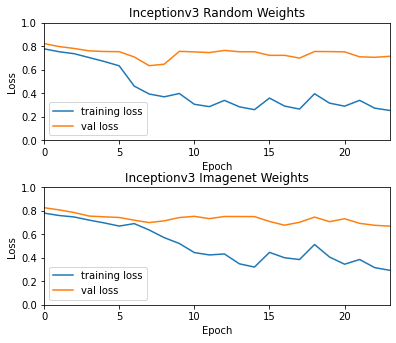

In [33]:
#Plotting loss against pretrained and random 
fig, axs = plt.subplots(2)
custom_xlim = (0, 23)
custom_ylim = (0, 1)
plt.setp(axs, xlim=custom_xlim, ylim=custom_ylim)

axs[0].plot(resnet152_loss, label = "training loss")
axs[0].plot(resnet152_val_loss, label = "val loss")
axs[0].set_title('Inceptionv3 Random Weights')
axs[0].legend()
axs[1].plot(inceptionv3_loss, label = "training loss")
axs[1].plot(inceptionv3_val_loss, label = "val loss")
axs[1].set_title('Inceptionv3 Imagenet Weights')
axs[1].legend()

for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='Loss')


plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=0.9,
                    top=0.99,
                    wspace=0.4,
                    hspace=0.4)

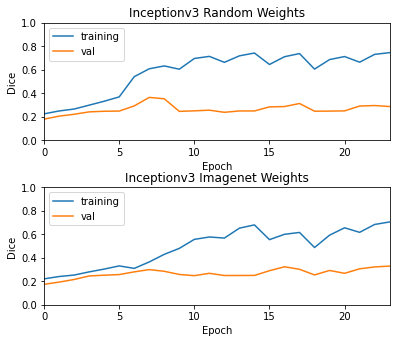

In [34]:
#Plotting dice against pretrained and random 
fig, axs = plt.subplots(2)
custom_xlim = (0, 23)
custom_ylim = (0, 1)
plt.setp(axs, xlim=custom_xlim, ylim=custom_ylim)

axs[0].plot(resnet152_f1, label = "training")
axs[0].plot(resnet152_val_f1, label = "val")
axs[0].set_title('Inceptionv3 Random Weights')
axs[0].legend()
axs[1].plot(inceptionv3_f1, label = "training")
axs[1].plot(inceptionv3_val_f1, label = "val")
axs[1].set_title('Inceptionv3 Imagenet Weights')
axs[1].legend()

for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='Dice')


plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=0.9,
                    top=0.99,
                    wspace=0.4,
                    hspace=0.4)

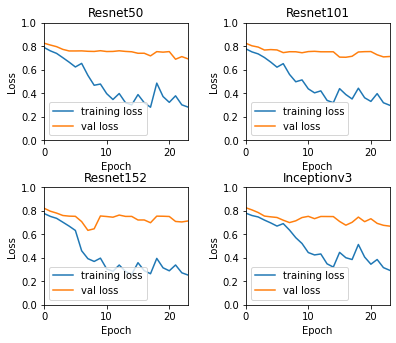

In [23]:
#Plot loss 
fig, axs = plt.subplots(2, 2)
custom_xlim = (0, 23)
custom_ylim = (0, 1)
plt.setp(axs, xlim=custom_xlim, ylim=custom_ylim)

axs[0, 0].plot(resnet50_loss, label = "training loss")
axs[0, 0].plot(resnet50_val_loss, label = "val loss")
axs[0, 0].set_title('Resnet50')
axs[0, 0].legend()
axs[0, 1].plot(resnet101_loss, label = "training loss")
axs[0, 1].plot(resnet101_val_loss, label = "val loss")
axs[0, 1].set_title('Resnet101')
axs[0, 1].legend()
axs[1, 0].plot(resnet152_loss, label = "training loss")
axs[1, 0].plot(resnet152_val_loss, label = "val loss")
axs[1, 0].set_title('Resnet152')
axs[1, 0].legend()
axs[1, 1].plot(inceptionv3_loss, label = "training loss")
axs[1, 1].plot(inceptionv3_val_loss, label = "val loss")
axs[1, 1].set_title('Inceptionv3')
axs[1, 1].legend()

for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='Loss')


plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=0.9,
                    top=0.99,
                    wspace=0.4,
                    hspace=0.4)


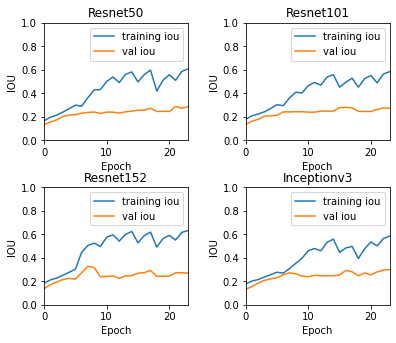

In [24]:
#Plot iou 
fig, axs = plt.subplots(2, 2)
custom_xlim = (0, 23)
custom_ylim = (0, 1)
plt.setp(axs, xlim=custom_xlim, ylim=custom_ylim)

axs[0, 0].plot(resnet50_iou, label = "training iou")
axs[0, 0].plot(resnet50_val_iou, label = "val iou")
axs[0, 0].set_title('Resnet50')
axs[0, 0].legend()
axs[0, 1].plot(resnet101_iou, label = "training iou")
axs[0, 1].plot(resnet101_val_iou, label = "val iou")
axs[0, 1].set_title('Resnet101')
axs[0, 1].legend()
axs[1, 0].plot(resnet152_iou, label = "training iou")
axs[1, 0].plot(resnet152_val_iou, label = "val iou")
axs[1, 0].set_title('Resnet152')
axs[1, 0].legend()
axs[1, 1].plot(inceptionv3_iou, label = "training iou")
axs[1, 1].plot(inceptionv3_val_iou, label = "val iou")
axs[1, 1].set_title('Inceptionv3')
axs[1, 1].legend()

for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='IOU')

plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=0.9,
                    top=0.99,
                    wspace=0.4,
                    hspace=0.4)


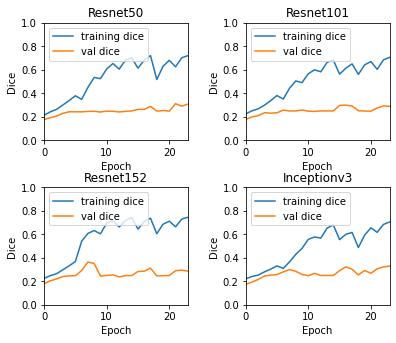

In [28]:
#Plot f1 
fig, axs = plt.subplots(2, 2)
custom_xlim = (0, 23)
custom_ylim = (0, 1)
plt.setp(axs, xlim=custom_xlim, ylim=custom_ylim)
axs[0, 0].plot(resnet50_f1, label = "training dice")
axs[0, 0].plot(resnet50_val_f1, label = "val dice")
axs[0, 0].set_title('Resnet50')
axs[0, 0].legend()
axs[0, 1].plot(resnet101_f1, label = "training dice")
axs[0, 1].plot(resnet101_val_f1, label = "val dice")
axs[0, 1].set_title('Resnet101')
axs[0, 1].legend()
axs[1, 0].plot(resnet152_f1, label = "training dice")
axs[1, 0].plot(resnet152_val_f1, label = "val dice")
axs[1, 0].set_title('Resnet152')
axs[1, 0].legend()
axs[1, 1].plot(inceptionv3_f1, label = "training dice")
axs[1, 1].plot(inceptionv3_val_f1, label = "val dice")
axs[1, 1].set_title('Inceptionv3')
axs[1, 1].legend()

for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='Dice')

plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=0.9,
                    top=0.99,
                    wspace=0.4,
                    hspace=0.4)

In [ ]:
inceptionv3_n40_49_loss = [[0.3951091766357422, 0.33990439772605896, 0.3145109713077545], [0.319307416677475, 0.26524895429611206, 0.2522960603237152], [0.4179610311985016, 0.35281869769096375, 0.3217611610889435], [0.3358364999294281, 0.26537802815437317, 0.23414503037929535], [0.3113546073436737, 0.2544877529144287, 0.2378336787223816], [0.32299739122390747, 0.25773489475250244, 0.2423989325761795], [0.4641564190387726, 0.34691813588142395, 0.31376340985298157], [0.3412144184112549, 0.2648826539516449, 0.24654518067836761], [0.3129885792732239, 0.254965603351593, 0.2459167242050171], [0.3270586133003235, 0.25004076957702637, 0.23614269495010376]]
inceptionv3_n40_49_val_loss = [[0.5467121005058289, 0.5655361413955688, 0.5596164464950562], [0.7151218056678772, 0.7276116013526917, 0.7168987989425659], [0.6042144894599915, 0.61988765001297, 0.6032494902610779], [0.4690472483634949, 0.4755338728427887, 0.475854754447937], [0.5727385878562927, 0.5846730470657349, 0.5937089920043945], [0.6282491087913513, 0.6188031435012817, 0.6217407584190369], [0.7403494119644165, 0.7365757822990417, 0.7367969155311584], [0.7011608481407166, 0.703277051448822, 0.7024741172790527], [0.4805977940559387, 0.4929109215736389, 0.48624563217163086], [0.6558709740638733, 0.6455743908882141, 0.6417667269706726]]
inceptionv3_n40_49_iou = [[0.4858670234680176, 0.5356087684631348, 0.559637188911438], [0.5584383606910706, 0.6161773800849915, 0.6291002631187439], [0.47455137968063354, 0.5286945104598999, 0.557469367980957], [0.5474417209625244, 0.6186904311180115, 0.6503292322158813], [0.5677663087844849, 0.6269863247871399, 0.6451388597488403], [0.5558291077613831, 0.6222746968269348, 0.6411997675895691], [0.4408222436904907, 0.5437682867050171, 0.5747480988502502], [0.5416920185089111, 0.6153305172920227, 0.6373429298400879], [0.5654338002204895, 0.6237600445747375, 0.6357429027557373], [0.5577046871185303, 0.6354596614837646, 0.6513447165489197]]
inceptionv3_n40_49_val_iou = [[0.39858895540237427, 0.3812780976295471, 0.3872092068195343], [0.268393874168396, 0.26142704486846924, 0.26823359727859497], [0.3464967608451843, 0.3363325297832489, 0.34626245498657227], [0.44817185401916504, 0.4430326521396637, 0.4431832730770111], [0.37826767563819885, 0.3680083751678467, 0.3579651713371277], [0.331015408039093, 0.34008562564849854, 0.33787697553634644], [0.2552194893360138, 0.2575460970401764, 0.25641658902168274], [0.274798184633255, 0.27247560024261475, 0.2731710374355316], [0.45642706751823425, 0.44606661796569824, 0.45243287086486816], [0.31602588295936584, 0.3248003423213959, 0.32637760043144226]]
inceptionv3_n40_49_f1 = [[0.6050005555152893, 0.6600325703620911, 0.685203492641449], [0.6773536801338196, 0.735931932926178, 0.7483134269714355], [0.5836774706840515, 0.6463902592658997, 0.6778870820999146], [0.6645437479019165, 0.7347763180732727, 0.7661446332931519], [0.6889576315879822, 0.7456488609313965, 0.7626499533653259], [0.677689254283905, 0.7423815727233887, 0.7577624917030334], [0.535843551158905, 0.6530818343162537, 0.686236560344696], [0.6597955226898193, 0.7348020672798157, 0.7539524435997009], [0.6882408857345581, 0.7445448040962219, 0.7539739608764648], [0.6727312803268433, 0.7501365542411804, 0.7613555192947388]]
inceptionv3_n40_49_val_f1 = [[0.45328789949417114, 0.43446388840675354, 0.44038352370262146], [0.2848781943321228, 0.27238836884498596, 0.2831012010574341], [0.39578554034233093, 0.38011232018470764, 0.3967505097389221], [0.5248187780380249, 0.5178768038749695, 0.5176219344139099], [0.42728015780448914, 0.41625353693962097, 0.40642017126083374], [0.3717508018016815, 0.38119691610336304, 0.37825924158096313], [0.2596505284309387, 0.2634241282939911, 0.2632030248641968], [0.297076940536499, 0.2950674891471863, 0.295828253030777], [0.5180661082267761, 0.5060095191001892, 0.5127831101417542], [0.3460901379585266, 0.3560880422592163, 0.359586238861084]]